In [61]:
import numpy as np 
import matplotlib.pyplot as plt
import mpmath
import pymaster as nmt
import healpy as hp
import gc
import time
from tqdm import tqdm
import jax.numpy as jnp
%matplotlib inline

$$f = s + n$$

$$ < f_i^2>  = \sigma_s^2 +  \sigma_N^2$$

$$ < f_i^2>  = \sigma_s^2



In [62]:
def sample_in_gal_coord(n_points):
        '''The galactic latitude gb spans a range of [-90, 90]. 
        The galactic longitude gl spans a range of [0, 360]'''        
        
        phi, cos_theta = np.random.uniform([0, -1], [2*np.pi, 1], size = (n_points, 2)).T
    
        theta = np.pi/2 - np.arccos(cos_theta)
        
        gl = (phi*180)/np.pi
        gb = (theta*180)/np.pi
        
        
        return gl ,gb

In [63]:
n_samples = 1000

gl, gb = sample_in_gal_coord(n_samples)

sin_gl = np.sin(gl*np.pi/180)
cos_gl = np.cos(gl*np.pi/180)
sin_gb = np.sin(gb*np.pi/180)
cos_gb = np.cos(gb*np.pi/180)



cos_theta = sin_gb[None,:] * sin_gb[:, None] + cos_gb[None,:] * cos_gb[:, None] * np.cos(gl[None,:]*np.pi/180 - gl[:, None]*np.pi/180)

gc.collect()

41538

In [64]:
nside =256
lmin = 1
nell = 20
edges = np.unique(np.geomspace(lmin,3*nside,nell).astype(int))

cl_DMDM = np.load("/home/s59efara_hpc/covariance/test_cl_kappadm.npy")[:, 0 ,0]
map = hp.synfast(cl_DMDM, nside=nside, lmax=cl_DMDM.shape[0]-1, new=True)
ipix = hp.ang2pix(nside, np.pi/2 - gb*np.pi/180, gl*np.pi/180)
w = np.ones_like(ipix)



# beware of the binning scheme and the values to be added to the  
b = nmt.NmtBin.from_edges(edges[:-1], edges[1:])
# b = nmt.NmtBin.from_lmax_linear(3*nside - 1, nell)
f_vals = map[ipix] - np.mean(map[ipix])
f_nmt = nmt.NmtFieldCatalog(positions = [gl, gb], weights=w, field = f_vals, lmax = 3*nside - 1, lonlat=True)
wasp = nmt.NmtWorkspace.from_fields(f_nmt, f_nmt, b)

Sl_coupled = nmt.compute_coupled_cell(f_nmt, f_nmt) # the coupled, noise subtracted power spectrum 
Nf = f_nmt.Nf
Cl = Sl_coupled + Nf 
Sl = wasp.decouple_cell(Sl_coupled)

Rl = Sl + Nf

In [65]:
npix = hp.nside2npix(nside)
f_sky = n_samples/npix

In [66]:
mcm = jnp.asarray(wasp.get_coupling_matrix())
mcm_inv = np.linalg.inv(mcm)

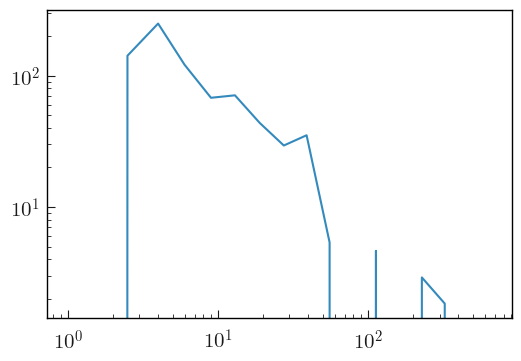

In [67]:
plt.loglog(b.get_effective_ells(), Sl[0,:])

In [68]:
from scipy.integrate import simpson
field_variance = simpson(Sl*b.get_effective_ells(),x = b.get_effective_ells())/(2*np.pi)
Nw_sigma_s = field_variance*f_nmt.Nw

In [69]:
noise_variance = (simpson(Nf*b.get_effective_ells(),x = b.get_effective_ells())/2./np.pi)/n_samples

In [70]:
var_f = np.var(f_vals)

In [71]:
w_ij_4pi = w[None, :]*w[:, None]/(4*np.pi)

In [72]:
mask_poles = jnp.where((cos_theta==1) | (cos_theta==-1))
w_ij_4pi[mask_poles] = 0.

In [73]:
def legendre_rec(x, l, P_l_1, P_l_2):
    
    result = ((2*l - 1) / l) * x * P_l_1 - ((l - 1) / l) * P_l_2
    return result

In [74]:
from jax import jit
legendre_rec_compiled = jit(legendre_rec)

In [75]:
cos_theta = jnp.array(cos_theta)
A = np.zeros((edges[-1], n_samples, n_samples))
p0 = jnp.ones_like(cos_theta)
p1 = cos_theta
for i in tqdm(np.arange(lmin, edges[-1])):
    if i == 0:
        p0 = np.ones_like(cos_theta)
        A[i, :,:] = np.array(w_ij_4pi*p0)
    elif i == 1:
        p1 = cos_theta
        A[i, :,:] = np.array(w_ij_4pi*p1)
    else:
        pn = legendre_rec_compiled(cos_theta, i, p1, p0)
        A [i,:,:] = np.array(w_ij_4pi*pn)
        p0 = p1
        p1 = pn

100%|██████████| 767/767 [00:02<00:00, 257.30it/s]


In [104]:
A[3, 0, 0]

Array(0.07957746, dtype=float32)

In [76]:
del p0, p1, pn
gc.collect()

746

In [77]:
A = jnp.array(A)

In [78]:
term1_matrix = jnp.einsum('aij, bij->ab', A, A)
term1 = jnp.einsum('ka, lb, ab->kl', mcm_inv, mcm_inv, term1_matrix)

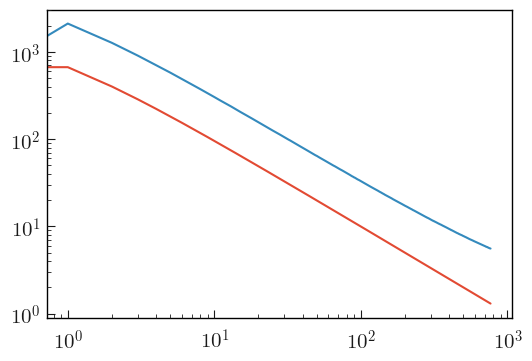

In [79]:
plt.loglog(np.arange(edges[-1]), jnp.diag(term1_matrix))
plt.loglog(np.arange(edges[-1]), 2e3/(2*np.arange(edges[-1]) + 1))

In [100]:
field_variance

array([17544.4943899])

In [ ]:
matrix_term = 2*term1*field_variance**2
matrix_term_modified = 2*term1*(field_variance)**2


In [81]:
numerical_term = (Nw_sigma_s)**2  - 2*(var_f**2)*jnp.sum(w*w*w*w)/(4*np.pi)**2
numerical_addition = jnp.einsum('ka, lb->kl', mcm_inv, mcm_inv)*numerical_term

In [82]:
Cov_N = matrix_term + numerical_addition

In [83]:
import numpy as np

def build_binning_matrix(edges, lmax):
    
    nbins = len(edges) - 1
    B = np.zeros((nbins, lmax))
    ell_eff = np.zeros(nbins)

    for b in range(nbins):
        ell_min, ell_max = edges[b], edges[b + 1]
        ells_in_bin = np.arange(ell_min, ell_max)
        Δℓ = len(ells_in_bin)
        if Δℓ > 0:
            B[b, ells_in_bin] = 1.0 / Δℓ
            ell_eff[b] = np.mean(ells_in_bin)
    return B, ell_eff


In [84]:
Binning, ell_eff = build_binning_matrix(edges, edges[-1])
Binning = jnp.array(Binning)

In [85]:
ells = b.get_effective_ells()

In [92]:
Cov_N_binned = Binning @ Cov_N @ Binning.T
field_variance_binned_cov = Binning @ matrix_term_modified @ Binning.T

In [93]:
import plothist

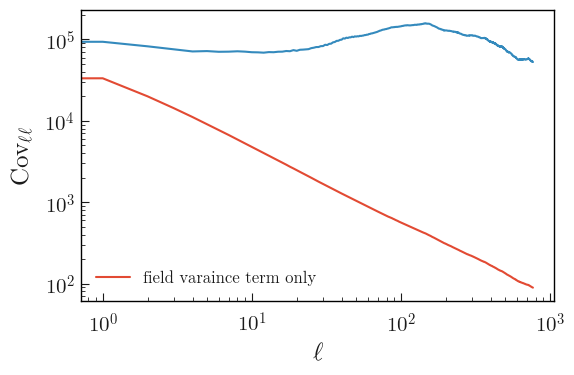

In [94]:

plt.loglog(np.arange(edges[-1]), jnp.diag(Cov_N))
plt.loglog(np.arange(edges[-1]), jnp.diag(matrix_term_modified), label='field varaince term only')

# plt.loglog(ells, 2*(Sl[0,:] + 4*np.pi*field_variance/n_samples)**2/(f_sky*delta_ell*(2*ells + 1)), label = 'variance expectation')
        
plt.xlabel(r'$\ell$')
plt.ylabel(r'$Cov_{\ell \ell}$')
plt.legend()
plt.tight_layout()

plt.savefig('covariance_comparison_cpcl_jax.png')

In [95]:
data = np.load('/home/s59efara_hpc/covariance/data_sets/varied_numbers_compare_field_variance.npy')


In [96]:
from scipy.integrate import simpson

cl_00 = np.load("/home/s59efara_hpc/covariance/test_cl_kappadm.npy")[:, 0, 0]
clth_binned = b.bin_cell(cl_00[None, :3*nside])

field_variance = simpson(clth_binned*b.get_effective_ells(),x = b.get_effective_ells())/2./np.pi



sigma_th = (2*(clth_binned)**2)/(2*(2*ells + 1))

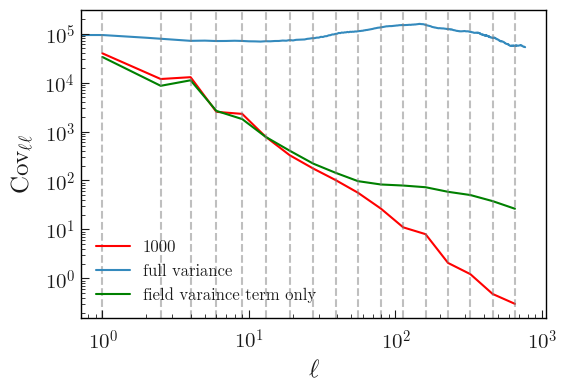

In [ ]:
n_sources_list = np.array([1000], dtype=int)    

# fig, ax = plt.subplots(figsize = (12, 8))

for i in range(len(n_sources_list)):
    ls, cls, sigma, _, _ = data[i]
    plt.loglog(ls, sigma, label = n_sources_list[i], color = 'red')
    # sigma_th = (2*(clth_binned + 4*np.pi*field_variance/n_sources_list[i])**2)/(delta_ell*(2*ells + 1))
# plt.loglog(np.arange(0, edges[-1], 1), jnp.diag(Cov_N), label='full variance')

plt.loglog(ells, jnp.diag(field_variance_binned_cov), label='field varaince term only', color = 'green')

for i in ells:
    plt.axvline(x=i, color='gray', linestyle='--', alpha=0.5)


plt.xlabel(r'$\ell$')
plt.ylabel(r'$Cov_{\ell \ell}$')
plt.legend()

plt.savefig('covariance_comparison_cpcl_jax_nsource_1000.png', dpi = 300, bbox_inches='tight')

(-1000.0, 10.0)

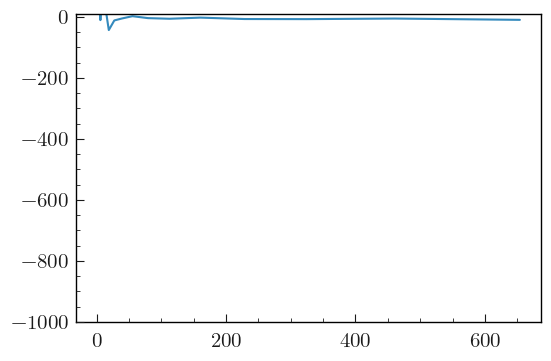

In [60]:
plt.plot( ells, sigma - jnp.diag(field_variance_binned_cov))
plt.ylim(-1e3, 1e1)

In [34]:
p_ab = jnp.einsum('aij, bij->ab', A, A)

Calculating sums (this may take a moment)...


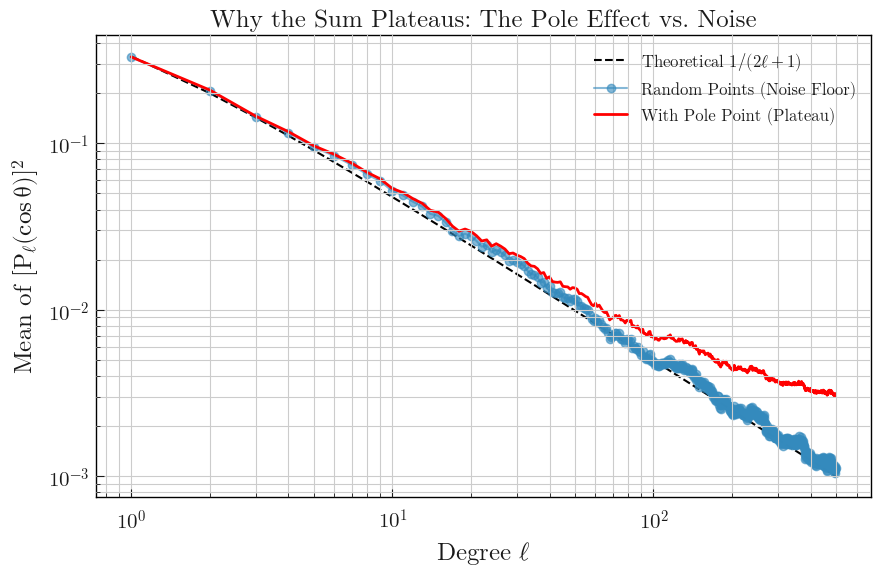

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import eval_legendre

# 1. Setup degrees l to test
l_values = np.arange(1, 500)

# 2. Define two sets of points
# Case A: Random points on the sphere (Expected behavior)
n_points = 500
theta_random = np.arccos(np.random.uniform(-1, 1, n_points)) # Uniform on sphere
x_random = np.cos(theta_random)

# Case B: Random points + ONE point at the pole (The Plateau)
x_pole = np.concatenate([x_random, [1.0]]) # Adding cos(0) = 1

# 3. Calculate sum of squared Legendre polynomials
sum_random = []
sum_pole = []

print("Calculating sums (this may take a moment)...")
for l in l_values:
    # Evaluate P_l(x) for all points
    pl_random = eval_legendre(l, x_random)
    pl_pole   = eval_legendre(l, x_pole)
    
    # Calculate Mean of squares (Normalizing by N to see the average behavior)
    sum_random.append(np.mean(pl_random**2))
    sum_pole.append(np.mean(pl_pole**2))

# 4. Plotting
plt.figure(figsize=(10, 6))

# Theory curve (1 / (2l + 1))
theory = 1 / (2 * l_values + 1)
plt.loglog(l_values, theory, 'k--', label=r'Theoretical $1/(2\ell+1)$')

# Random points
plt.loglog(l_values, sum_random, 'o-', alpha=0.6, label='Random Points (Noise Floor)')

# With Pole
plt.loglog(l_values, sum_pole, 'r-', linewidth=2, label='With Pole Point (Plateau)')

plt.xlabel(r'Degree $\ell$')
plt.ylabel(r'Mean of $[P_\ell(\cos\theta)]^2$')
plt.title('Why the Sum Plateaus: The Pole Effect vs. Noise')
plt.grid(True, which="both", ls="-")
plt.legend()
plt.show()